In [1]:
import pandas as pd
from pandas_datareader import data, wb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
symbols = ['AAPL', 'MSFT', 'JPM', 'DB', 'GLD'] #Ticker names: Apple, Microsoft, JP Morgan, Deutsche Bank, Gold
noa = len(symbols)

In [4]:
d = pd.DataFrame()
for sym in symbols:
    d[sym] = data.DataReader(sym, data_source='yahoo',start='2015-01-01',end='2019-12-12')['Adj Close']
d.columns = symbols                      

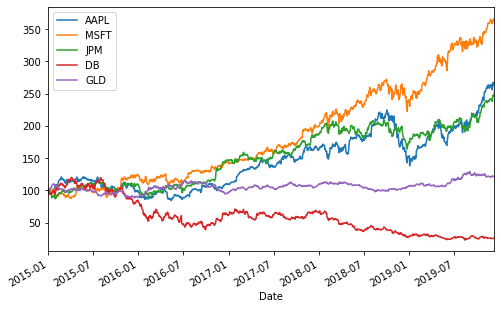

In [5]:
(d / d.iloc[0] * 100).plot(figsize=(8, 5))

In [6]:
rets = np.log(d / d.shift(1))

In [7]:
rets.mean() * 252

AAPL    0.199123
MSFT    0.263221
JPM     0.187777
DB     -0.265554
GLD     0.040016
dtype: float64

In [8]:
rets.cov() * 252

,AAPL,MSFT,JPM,DB,GLD
AAPL,0.062236,0.033522,0.022774,0.027721,-0.004194
MSFT,0.033522,0.054492,0.024063,0.028361,-0.003822
JPM,0.022774,0.024063,0.044370,0.050008,-0.008390
DB,0.027721,0.028361,0.050008,0.147716,-0.009944
GLD,-0.004194,-0.003822,-0.008390,-0.009944,0.015864


In [9]:
weights = np.random.random(noa)
weights /= np.sum(weights)

In [10]:
weights

array([0.10958815, 0.09984905, 0.38693276, 0.04897065, 0.35465938])

In [11]:
exp_ret = np.sum(rets.mean() * weights) * 252 #expected portfolio return

In [12]:
port_var = np.dot(weights.T, np.dot(rets.cov() * 252, weights))# expected portfolio variance

In [13]:
port_vol = np.sqrt(port_var) #expected portfolio Standard Deviation/volatility

In [14]:
prets = []
pvols = []

for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights) 
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T,np.dot(rets.cov() * 252, weights))))

prets = np.array(prets)
pvols = np.array(pvols)

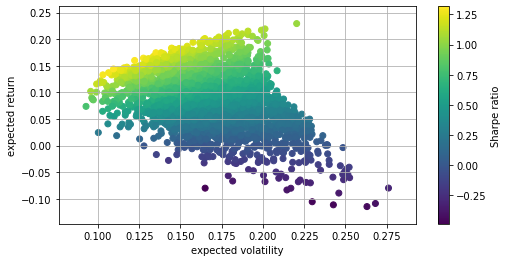

In [15]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=prets / pvols, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return') 
plt.colorbar(label='Sharpe ratio')

In [16]:
def statistics(weights):
    ''' Returns portfolio statistics.
    Parameters
    ==========
    weights : array-like
    weights for different securities in portfolio
    Returns
    =======
    pret : float
    expected portfolio return
    pvol : float
    expected portfolio volatility
    pret / pvol : float
    Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))) 
    return np.array([pret, pvol, pret / pvol])

In [17]:
import scipy.optimize as sco

In [18]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [19]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [20]:
bnds = tuple((0, 1) for x in range(noa))

In [21]:
noa * [1. / noa,]

[0.2, 0.2, 0.2, 0.2, 0.2]

In [22]:
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

In [23]:
opts

     fun: -1.3436173261478719
     jac: array([-5.64336777e-04, -1.07267499e-03, -4.01854515e-04,  4.35552593e+00,
        1.03577971e-03])
 message: 'Optimization terminated successfully.'
    nfev: 59
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([4.46683654e-02, 2.89127463e-01, 2.46718928e-01, 6.23904029e-16,
       4.19485244e-01])

In [24]:
opts['x'].round(3)

array([0.045, 0.289, 0.247, 0.   , 0.419])

In [25]:
statistics(opts['x']).round(3)

array([0.148, 0.11 , 1.344])

In [26]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [27]:
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

In [28]:
optv['x'].round(3)

array([0.049, 0.049, 0.25 , 0.   , 0.651])

In [29]:
statistics(optv['x']).round(3)

array([0.096, 0.089, 1.081])

In [30]:
def min_func_port(weights):
    return statistics(weights)[1]

In [31]:
trets = np.linspace(0.0, 0.25, 50) 
tvols = []

for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},{'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])

tvols = np.array(tvols)

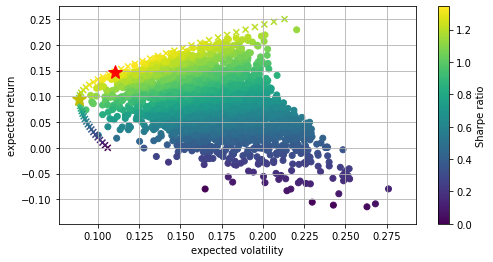

In [32]:
plt.figure(figsize=(8, 4)) 
plt.scatter(pvols, prets,c=prets / pvols, marker='o') # random portfolio composition
plt.scatter(tvols, trets,c=trets / tvols, marker='x') # efficient frontier
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize=15.0) # portfolio with highest Sharpe ratio 
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=15.0) # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [33]:
import numpy.random as npr

In [35]:
S0 = 100 # initial value
r = 0.05 # constant short rate 
sigma = 0.25 # constant volatility 
T = 2.0 # in years
I = 10000 # number of random draws 
M = 50
dt = T / M
S = np.zeros((M + 1, I))
S[0] = S0
for t in range(1, M + 1):
    S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * npr.standard_normal(I))
    #Black-Scholes-Merton Equation

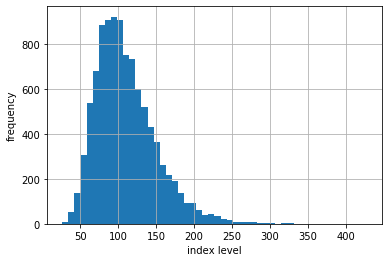

In [36]:
plt.hist(S[-1], bins=50)
plt.xlabel('index level')
plt.ylabel('frequency')
plt.grid(True)

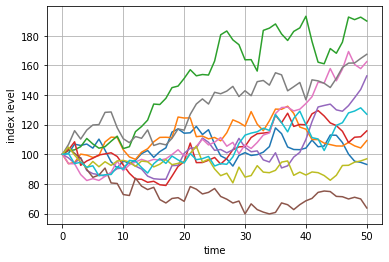

In [37]:
plt.plot(S[:, :10], lw=1.5)
plt.xlabel('time')
plt.ylabel('index level')
plt.grid(True)